In [1]:
import torch
import matplotlib.pyplot as plt
import torchvision
from torch import nn
from pathlib import Path
import pandas as pd
import os
SEED = 137
BATCH_SIZE = 16

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
weights = torchvision.models.EfficientNet_B4_Weights.DEFAULT
effnet_b4_transform = weights.transforms()

In [4]:
transform = torchvision.transforms.Compose([torchvision.transforms.TrivialAugmentWide(num_magnitude_bins=7),
                                effnet_b4_transform])

In [5]:
dataset_dir = Path('dataset/Flowers102')
train_data = torchvision.datasets.Flowers102(dataset_dir,
                                                   split='train',
                                                   transform=transform,
                                                   download=True)
test_data = torchvision.datasets.Flowers102(dataset_dir,
                                                   split='test',
                                                   transform=effnet_b4_transform,
                                                   download=True)

100%|██████████| 344862509/344862509 [00:11<00:00, 28775623.62it/s]


Extracting dataset/Flowers102/flowers-102/102flowers.tgz to dataset/Flowers102/flowers-102


100%|██████████| 502/502 [00:00<00:00, 696737.46it/s]


100%|██████████| 14989/14989 [00:00<00:00, 15740716.74it/s]


In [6]:
train_data

Dataset Flowers102
    Number of datapoints: 1020
    Root location: dataset/Flowers102
    split=train
    StandardTransform
Transform: Compose(
               TrivialAugmentWide(num_magnitude_bins=7, interpolation=InterpolationMode.NEAREST, fill=None)
               ImageClassification(
               crop_size=[380]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )
           )

In [7]:
test_data

Dataset Flowers102
    Number of datapoints: 6149
    Root location: dataset/Flowers102
    split=test
    StandardTransform
Transform: ImageClassification(
               crop_size=[380]
               resize_size=[384]
               mean=[0.485, 0.456, 0.406]
               std=[0.229, 0.224, 0.225]
               interpolation=InterpolationMode.BICUBIC
           )

In [8]:
train_data[0][0].size()

torch.Size([3, 380, 380])

In [9]:
train_data[0][1]

0

In [10]:
train_targets = []
for i in range(len(train_data)):
  train_targets.append(train_data[i][1])

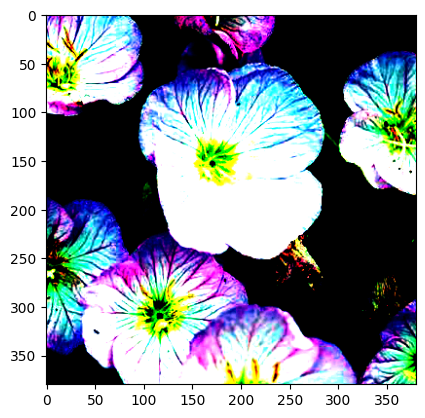

In [11]:
plt.imshow(train_data[0][0].permute(1, 2, 0));

In [12]:
df = pd.DataFrame(train_targets)
df.value_counts().min(), df.value_counts().max(), df.value_counts().median(), df.value_counts().mean()

(10, 10, 10.0, 10.0)

In [13]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=os.cpu_count())
test_dataloader = torch.utils.data.DataLoader(dataset=test_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=False,
                                               num_workers=os.cpu_count())

In [14]:
from torchvision.models import efficientnet_b4
effnet_b4 = efficientnet_b4(weights=weights)

Downloading: "https://download.pytorch.org/models/efficientnet_b4_rwightman-7eb33cd5.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b4_rwightman-7eb33cd5.pth
100%|██████████| 74.5M/74.5M [00:00<00:00, 226MB/s]


In [15]:
effnet_b4

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActiv

In [16]:
for param in effnet_b4.features.parameters():
  param.requires_grad = False

In [17]:
effnet_b4.classifier = nn.Sequential(nn.Dropout(p=0.4, inplace=True),
                                     nn.Linear(in_features=1792, out_features=102, bias=True))

In [18]:
!wget https://github.com/Illalla/helper_functions_for_pytorch/raw/main/helper_fns_for_torch.py

hidden

In [19]:
from helper_fns_for_torch import train_cls_model

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer = torch.optim.Adam(params=effnet_b4.parameters(),
                             lr=0.001,
                             weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(gamma=0.8, optimizer=optimizer, verbose=True)

loss_curves = train_cls_model(effnet_b4,
                train_dataloader,
                test_dataloader,
                optimizer,
                loss_fn,
                epochs=8,
                device=device,
                scheduler=scheduler)

Adjusting learning rate of group 0 to 1.0000e-03.


  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 1
 train_loss: 4.4969 | train_acc: 0.1553 | test_loss: 4.2805 | test_acc: 0.4360
Adjusting learning rate of group 0 to 8.0000e-04.
Epoch: 2
 train_loss: 4.0765 | train_acc: 0.6335 | test_loss: 3.9792 | test_acc: 0.6575
Adjusting learning rate of group 0 to 6.4000e-04.
Epoch: 3
 train_loss: 3.7770 | train_acc: 0.7718 | test_loss: 3.7645 | test_acc: 0.7271
Adjusting learning rate of group 0 to 5.1200e-04.
Epoch: 4
 train_loss: 3.5454 | train_acc: 0.8291 | test_loss: 3.6103 | test_acc: 0.7409
Adjusting learning rate of group 0 to 4.0960e-04.
Epoch: 5
 train_loss: 3.3701 | train_acc: 0.8604 | test_loss: 3.5069 | test_acc: 0.7437
Adjusting learning rate of group 0 to 3.2768e-04.
Epoch: 6
 train_loss: 3.2342 | train_acc: 0.8691 | test_loss: 3.3775 | test_acc: 0.7732
Adjusting learning rate of group 0 to 2.6214e-04.
Epoch: 7
 train_loss: 3.1361 | train_acc: 0.8805 | test_loss: 3.3077 | test_acc: 0.7719
Adjusting learning rate of group 0 to 2.0972e-04.
Epoch: 8
 train_loss: 3.0724 | tra

In [20]:
i = 0
for param in effnet_b4.features.parameters():
  if i > len(effnet_b4.features)-3:
    param.requires_grad = True
  i += 1

In [21]:
from helper_fns_for_torch import train_cls_model

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.01)
optimizer = torch.optim.Adam(params=effnet_b4.parameters(),
                             lr=0.00001,
                             weight_decay=0.0001)

loss_curves = train_cls_model(effnet_b4,
                train_dataloader,
                test_dataloader,
                optimizer,
                loss_fn,
                epochs=5,
                device=device,
                scheduler=None)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1
 train_loss: 2.9382 | train_acc: 0.9085 | test_loss: 3.1184 | test_acc: 0.8023
Epoch: 2
 train_loss: 2.7858 | train_acc: 0.8900 | test_loss: 2.8977 | test_acc: 0.8278
Epoch: 3
 train_loss: 2.6103 | train_acc: 0.9033 | test_loss: 2.7481 | test_acc: 0.8304
Epoch: 4
 train_loss: 2.4293 | train_acc: 0.8717 | test_loss: 2.5207 | test_acc: 0.8328
Epoch: 5
 train_loss: 2.2832 | train_acc: 0.8708 | test_loss: 2.3852 | test_acc: 0.8284


In [22]:
model_name = "fine_tuned_effnet_b4.pth"
save_dir_path = Path("saved_models")
save_dir_path.mkdir(parents=True,
                    exist_ok=True)
model_path = save_dir_path / model_name
torch.save(obj=effnet_b4.state_dict(),
           f=model_path)